In [163]:
from gensim.models import Doc2Vec
from sklearn import decomposition
import numpy as np  
import sys
import operator
from sklearn import metrics
from sklearn import preprocessing
from sklearn import cross_validation
from adjustText import adjust_text

import heapq
import pandas as pd
import random as rnd
from random import shuffle
import collections
import matplotlib.ticker as ticker

from heapq import nlargest

from twitch import commons

%pylab inline
matplotlib.use('Agg')
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.pylab as pylab

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy
//anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
df = pd.read_csv('./user_chat_counts.csv.dat', header=None, names=['user', 'total', 'male', 'female'])
df['female_chat_percentage'] = (df.female*100)/df.total

print('all users: ' + str(len(df.index)))

print('users with atleast 100 messages: ' + str(len(df[df.total >= 100].index)))

all_users = df[(df.total >= 100)]
male_only_users = df[(df.total >= 100) & (df.female_chat_percentage == 0)].user.values.tolist()
female_only_users = df[(df.total >= 100) & (df.female_chat_percentage == 100)].user.values.tolist()

all users: 1818028
users with atleast 100 messages: 93898


In [5]:
female_channels = [line.strip().split(',')[0] for line in open('../female_channels.csv', 'r')]
male_channels = [line.strip().split(',')[0] for line in open('../male_channels.csv', 'r')]

In [8]:
channel_chat_logs = {}
for female in female_channels:
    message = []
    with open('../../data/channel_chat_logs/cleaned/' + female + "_chat_log.csv") as f:
        for line in f:
            splits = line.split(',')
            message.append(splits[3])
    channel_chat_logs[female] = ' '.join(message)
    
for male in male_channels:
    message = []
    with open('../../data/channel_chat_logs/cleaned/' + male + "_chat_log.csv") as f:
        for line in f:
            splits = line.split(',')
            message.append(splits[3])
    channel_chat_logs[male] = ' '.join(message)

In [9]:
model = Doc2Vec.load('./user_all_chats.d2v')

In [46]:
def infer_channel_vector(channel_name):
    return model.infer_vector(channel_chat_logs[channel_name].split(), steps=5)

In [42]:
vectors = [model.docvecs[x] for x in female_only_users + male_only_users]

In [72]:
def get_gender_score(channel_name):
    k = 200
    channel_vector = infer_channel_vector(channel_name)
    cosine_similarities = []
    for v in user_vectors:
        cosine_similarities.append(commons.cosine_similarity(channel_vector, v))
    indices = sorted(range(len(cosine_similarities)), key=lambda i: cosine_similarities[i])[-1*k:]
    gender_sum = 0
    for i in indices:
        if i < len(female_only_users):
            gender_sum += 1
    
    gender_sum = gender_sum / k
    return gender_sum

In [75]:
less_popular_female = []
for f in female_channels[100:200]:
    less_popular_female.append(get_gender_score(f))

In [76]:
less_popular_male = []
for f in male_channels[100:200]:
    less_popular_male.append(get_gender_score(f))

(array([ 17.,  12.,   5.,  11.,   7.,   8.,   3.,   9.,   7.,   5.,   3.,
          3.,   1.,   2.,   0.,   1.,   4.,   0.,   2.]),
 array([ 0.        ,  0.05263158,  0.10526316,  0.15789474,  0.21052632,
         0.26315789,  0.31578947,  0.36842105,  0.42105263,  0.47368421,
         0.52631579,  0.57894737,  0.63157895,  0.68421053,  0.73684211,
         0.78947368,  0.84210526,  0.89473684,  0.94736842,  1.        ]),
 <a list of 19 Patch objects>)

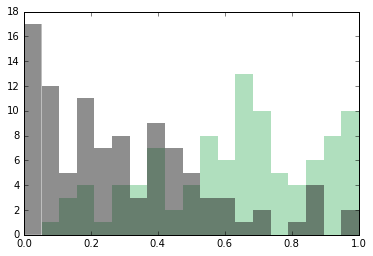

In [110]:
ax = plt.subplot(111)
ax.set_xlim(xmin=0)
bins = numpy.linspace(0, 1, 20)
ax.hist(less_popular_female, bins=bins, facecolor='#63c17e', alpha=0.5, linewidth=0)
ax.hist(less_popular_male, bins=bins, facecolor='#1F1F1F', alpha=0.5, linewidth=0)

In [85]:
popular_female = []
for f in female_channels[0:100]:
    popular_female.append(get_gender_score(f))

In [86]:
popular_male = []
for f in male_channels[0:100]:
    popular_male.append(get_gender_score(f))

(array([ 0.58,  0.13,  0.05,  0.09,  0.01,  0.02,  0.03,  0.03,  0.04,
         0.01,  0.  ,  0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ]),
 array([ 0.        ,  0.05263158,  0.10526316,  0.15789474,  0.21052632,
         0.26315789,  0.31578947,  0.36842105,  0.42105263,  0.47368421,
         0.52631579,  0.57894737,  0.63157895,  0.68421053,  0.73684211,
         0.78947368,  0.84210526,  0.89473684,  0.94736842,  1.        ]),
 <a list of 19 Patch objects>)

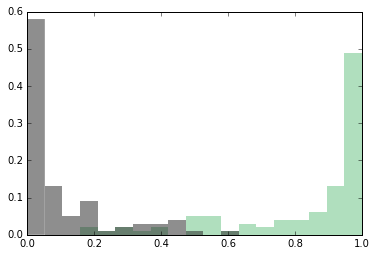

In [102]:
ax = plt.subplot(111)
ax.set_xlim(xmin=0)
bins = numpy.linspace(0, 1, 20)
weights = np.ones_like(popular_female)/float(len(popular_female))
ax.hist(popular_female, bins=bins, weights=weights, facecolor='#63c17e', alpha=0.5, linewidth=0)
weights = np.ones_like(popular_male)/float(len(popular_male))
ax.hist(popular_male, bins=bins, weights=weights, facecolor='#1F1F1F', alpha=0.5, linewidth=0)

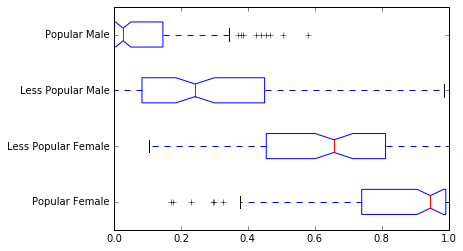

In [176]:
bp = plt.boxplot([popular_female, less_popular_female, less_popular_male, popular_male], sym='+',
               vert=0, whis=1.5, labels=['Popular Female', 'Less Popular Female', 'Less Popular Male', 'Popular Male'],
                notch=True, patch_artist=True)

# colors = ['#63c17e', '#d2f7dc', '#bababa', '#1F1F1F']
# for patch, color in zip(bp['boxes'], colors):
#     patch.set(facecolor=color, alpha=0.8)

plt.draw()
plt.savefig('channel_bias_from_users.svg', format='svg')

In [177]:
popular_female_channel_vectors = []
for f in female_channels[0:100]:
    popular_female_channel_vectors.append(infer_channel_vector(f))

In [178]:
less_popular_female_channel_vectors = []
for f in female_channels[100:200]:
    less_popular_female_channel_vectors.append(infer_channel_vector(f))

In [179]:
popular_male_channel_vectors = []
for f in male_channels[0:100]:
    popular_male_channel_vectors.append(infer_channel_vector(f))

In [180]:
less_popular_male_channel_vectors = []
for f in male_channels[100:200]:
    less_popular_male_channel_vectors.append(infer_channel_vector(f))

In [182]:
cluster_xy_vectors = commons.reduce_dim(popular_female_channel_vectors+less_popular_female_channel_vectors+\
                                        popular_male_channel_vectors+less_popular_male_channel_vectors, 'tsne')

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 1.013973
[t-SNE] Iteration 25: error = 1.1657873, gradient norm = 0.0229940
[t-SNE] Iteration 50: error = 1.1586989, gradient norm = 0.0193301
[t-SNE] Iteration 75: error = 0.8827348, gradient norm = 0.0129381
[t-SNE] Iteration 100: error = 1.0324005, gradient norm = 0.0154675
[t-SNE] Error after 100 iterations with early exaggeration: 1.032400
[t-SNE] Iteration 125: error = 0.8585256, gradient norm = 0.0097114
[t-SNE] Iteration 150: error = 1.0454255, gradient norm = 0.0158798
[t-SNE] Iteration 175: error = 1.2814893, gradient norm = 0.0189796
[t-SNE] Iteration 175: did not make any progress during the last 30 episodes. Finished.
[t-SNE] Error after 175 iterations: 1.281489


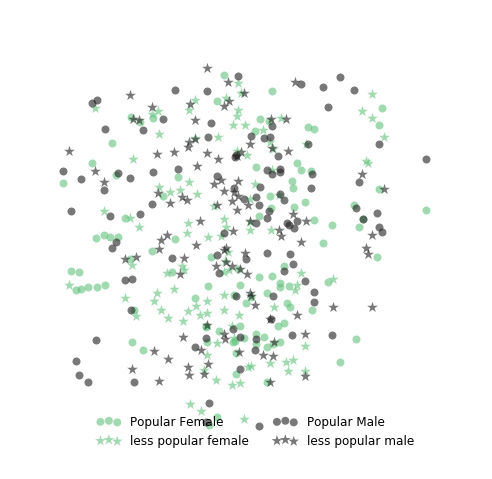

In [188]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

plt.scatter([x[0] for x in cluster_xy_vectors[0:100]], [x[1] for x in cluster_xy_vectors[0:100]],
            s=64, c='#63c17e', lw=0, alpha=0.6, label="Popular Female")
plt.scatter([x[0] for x in cluster_xy_vectors[100:200]], [x[1] for x in cluster_xy_vectors[100:200]],
            s=128, c='#63c17e', marker="*", lw=0, alpha=0.6, label="less popular female")

plt.scatter([x[0] for x in cluster_xy_vectors[0:100]], [x[1] for x in cluster_xy_vectors[200:300]],
            s=64, c='#1f1f1f', lw=0, alpha=0.6, label="Popular Male")
plt.scatter([x[0] for x in cluster_xy_vectors[100:200]], [x[1] for x in cluster_xy_vectors[300:400]],
            s=128, c='#1f1f1f', marker="*", lw=0, alpha=0.6, label="less popular male")

leg = plt.legend(loc='lower center', ncol=2)
leg.draw_frame(False)
plt.axis('off')
plt.draw()
plt.savefig('channel_clusters.svg', format='svg')